## COCOのまとめ
#### 学会で使ったcodeのまとめ

### 1. データセットの作成

目標：猫のみの画像，犬のみの画像，犬と猫が両方写っている画像の名前(path)をとってきて，listに入れる<br>
はじめに猫が写っている画像、犬が写っている画像を取ってくる

In [1]:
#データセット作成
#猫の画像のpathをリストに追加する。

B = []#cat

from pycocotools.coco import COCO
import os

# COCOデータセットのパスとアノテーションファイルのパスを設定する
data_dir = '/home/yishido/DATA/coco'
annotation_file = os.path.join(data_dir, 'annotations/instances_train2017.json')

# COCOデータセットを読み込む
coco = COCO(annotation_file)

# カテゴリIDとクラス名の対応を作成する
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {category['id']: category['name'] for category in categories}

# 抽出するラベルを指定する
target_label = 'cat'

# 画像IDと画像ファイル名の対応を作成する
image_id_to_file = {}
for image in coco.dataset['images']:
    image_id_to_file[image['id']] = image['file_name']

# アノテーション情報を取得し、指定したラベルの画像とラベル、領域のペアを列挙する
for annotation in coco.dataset['annotations']:
    image_id = annotation['image_id']
    label = category_id_to_name[annotation['category_id']]
    if label == target_label:
        image_file = image_id_to_file[image_id]
        B.append(image_file)
        bbox = annotation['bbox']
        #print(f"Image: {image_file}, Label: {label}, Bounding Box: {bbox}")

loading annotations into memory...
Done (t=19.85s)
creating index...
index created!


In [2]:
#犬の画像のpathをリストに追加する。

C = []#dog

# 抽出するラベルを指定する
target_label = 'dog'

# 画像IDと画像ファイル名の対応を作成する
image_id_to_file = {}
for image in coco.dataset['images']:
    image_id_to_file[image['id']] = image['file_name']

# アノテーション情報を取得し、指定したラベルの画像とラベル、領域のペアを列挙する
for annotation in coco.dataset['annotations']:
    image_id = annotation['image_id']
    label = category_id_to_name[annotation['category_id']]
    if label == target_label:
        image_file = image_id_to_file[image_id]
        C.append(image_file)
        bbox = annotation['bbox']
        # print(f"Image: {image_file}, Label: {label}, Bounding Box: {bbox}")

次に，猫のみ，犬のみを差事象で．また，猫と犬が両方写っている画像を余事象でとる

In [3]:
BnC = list(set(B) & set(C))#BnC 両方
B_C = list(set(B) - set(C))#B-C 猫のみ
C_B = list(set(C) - set(B))#C-B 犬のみ

確認してみる

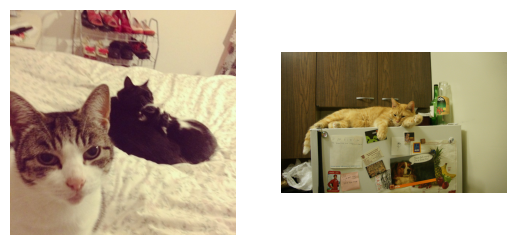

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image

random.seed(42)
random_element1 = random.choice(B_C)
random_element2 = random.choice(BnC)

image_path1 = f"../coco/images/train2017/{random_element1}"
image_path2 = f"../coco/images/train2017/{random_element2}"

plt.subplot(1,2,1)
plt.imshow(Image.open(image_path1))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Image.open(image_path2))

plt.axis('off')
plt.show()

取り出したpathをtxtfileに保存する

In [6]:
# with open('BnC.txt', 'w') as file:
#     for path in BnC:
#         file.write(path + '\n')

# with open('B_C.txt', 'w') as file:
#     for path in B_C:
#         file.write(path + '\n')

# with open('C_B.txt', 'w') as file:
#     for path in C_B:
#         file.write(path + '\n')

### 2.前処理

目標：自己教師ありに入れる為，正方形に直し，かつ直したときにずれるBBOXも計算して整える<br>
はじめに，特定のラベルのBBOXと画像をとってくる

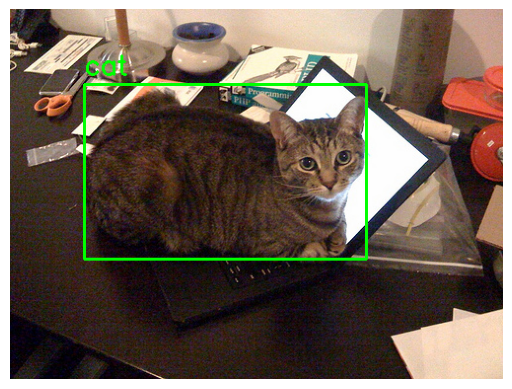

BBOX: [75.64, 76.13, 286.48, 177.04]
ラベル: cat
(375, 500, 3)


In [17]:
#特定のラベルのBBOXだけとってくる

import cv2

# 画像ファイルのパスを指定する
random.seed(39)
random_element = random.choice(B_C)
image_file = f"../coco/images/train2017/{random_element}"

# 画像ファイル名から画像IDを取得する
image_id = None
for image_info in coco.dataset['images']:
    if image_info['file_name'] == os.path.basename(image_file):
        image_id = image_info['id']
        break

if image_id is not None:
    # 画像IDに対応するアノテーション情報を取得する
    annotations_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotations_ids)

    # BBOXとラベルを表示する
    for annotation in annotations:
        bbox = annotation['bbox']
        label = coco.loadCats(annotation['category_id'])[0]['name']
        if label == 'cat' or label == 'dog':
            image = cv2.imread(image_file)
            # print(image.shape)
            x, y, w, h = map(int, bbox)
            # print(x,y,w,h)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # ラベルを描画する
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            # 画像をRGB形式に変換する
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # 画像を表示する
            plt.imshow(image_rgb)
            plt.axis('off')
            plt.show()
            
            print("BBOX:", bbox)
            print("ラベル:", label)
else:
    print("指定した画像ファイルに対応する画像IDが見つかりませんでした。")
print(image.shape)

次に正方形に直す．この際，reshape→cropの順番で直すため，reshapeの計算から行う

bbox:(45, 45, 170, 105)


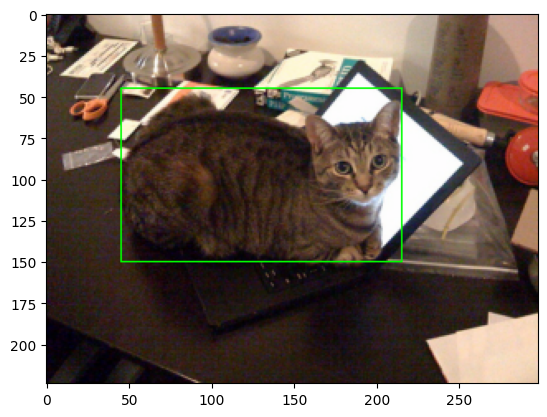

(224, 298, 3)


In [21]:
#画像をreshapeしてcropした後，BBOXの座標を計算する．
#reshapeする前とした後で比率を計算し，BBOXの座標にかける．

import torch
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406] #imagenetの正規化
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGENET_SIZE = 224

#２枚の画像を比べる(余白なし)

transform = transforms.Compose([
        transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((IMAGENET_MEAN), (IMAGENET_STD))
    ])

# 画像ファイルのパスを指定する
random.seed(39)
random_element = random.choice(B_C)
image_file = f"../coco/images/train2017/{random_element}"
img = cv2.imread(image_file)#PILだとshapeがよくわからんからcv2で読み込み
# print(f"imgのshpae:{img.shape}")
transformed_image = transform(Image.open(image_file)).to("cuda")#cv2からだとtorchに入んないからPILで読み込み(いらなそう)
# print(f"transformed_imageのshape:{transformed_image.shape}")
new_width = transformed_image.shape[2]
new_height = transformed_image.shape[1]


resize_ratio_x = new_width / img.shape[1]
resize_ratio_y = new_height / img.shape[0]

# print(f"x割合:{resize_ratio_x}")
# print(f"y割合:{resize_ratio_y}")

# 画像ファイル名から画像IDを取得する
image_id = None
for image_info in coco.dataset['images']:
    if image_info['file_name'] == os.path.basename(image_file):
        image_id = image_info['id']
        break

if image_id is not None:
    # 画像IDに対応するアノテーション情報を取得する
    annotations_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotations_ids)

    # BBOXとラベルを表示する
    for annotation in annotations:
        bbox = annotation['bbox']
        # print(bbox)
        resized_bbox = [
        int((bbox[0] * resize_ratio_x)),
        int((bbox[1] * resize_ratio_y)),
        int(bbox[2] * resize_ratio_x),
        int(bbox[3] * resize_ratio_y)
        ]
        label = coco.loadCats(annotation['category_id'])[0]['name']
        if label == 'cat' or label == 'dog':

            image1 = transformed_image.to("cpu").mul(torch.FloatTensor(IMAGENET_STD).view(3, 1, 1))
            image1 = image1.add(torch.FloatTensor(IMAGENET_MEAN).view(3, 1, 1)).detach().numpy()
            # print(image1.shape)
            x, y, w, h = map(int, resized_bbox)
            print(f"bbox:{x,y,w,h}")
            image_cv2 = np.transpose(image1, (1, 2, 0))
            image_cv2 = cv2.cvtColor(np.uint8(image_cv2 * 255), cv2.COLOR_RGB2BGR)#cv2に入れるためnumpy配列から直す torch->numpy->cv2
            cv2.rectangle(image_cv2, (x, y), (x + w, y + h), (0, 255, 0), 1)#cv2でbboxを追加する(cv2じゃなかったらもっと綺麗にかける，わざわざ返還させてる)

            # ラベルを描画する
            # cv2.putText(image_cv2, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            # 画像をRGB形式に変換する
            image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

            # 画像を表示する
            plt.imshow(image_rgb)
            # plt.axis('off')
            plt.show()
            
            # print("BBOX:", bbox)
            # print("ラベル:", label)
else:
    print("指定した画像ファイルに対応する画像IDが見つかりませんでした。")

print(image_rgb.shape)

画像サイズの縦(短い方)が224になった．次にcenercropも加えて正方形に直す．

bbox:(8, 45, 170, 105)


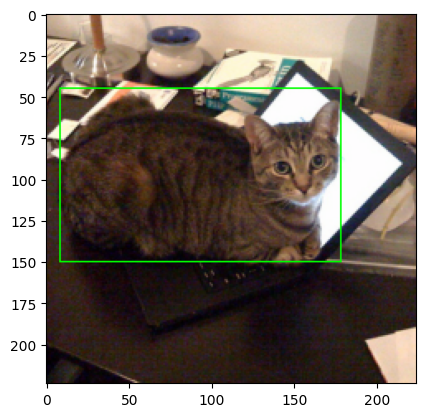

最後のshape(cv2):(224, 224, 3)


In [46]:
#左上が原点
#cv2.shpae (縦，横，chanel)
#PIL.size (横,縦)
#torch.shpae(縦,横)

IMAGENET_MEAN = [0.485, 0.456, 0.406] #imagenetの正規化
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGENET_SIZE = 224

#２枚の画像を比べる(余白なし)

transform1 = transforms.Resize(224)
# transform1 = transforms.Compose([
#         transforms.Resize(224),
#         transforms.ToTensor(),
#         transforms.Normalize((IMAGENET_MEAN), (IMAGENET_STD))
#     ])

# transform2 = transforms.CenterCrop(224),
transform2 = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((IMAGENET_MEAN), (IMAGENET_STD))
    ])

# 画像ファイルのパスを指定する
random.seed(39) 
random_element = random.choice(B_C)
image_file = f"../coco/images/train2017/{random_element}"
img = cv2.imread(image_file)#PILだとshapeがよくわからんからcv2で読み込み
# print(f"最初のshpae(cv2):{img.shape}")
reshaeped_im = transform1(Image.open(image_file))
# print(f"reshapeした後のshape(PIL):{reshaeped_im.size}")
transformed_image = transform2(reshaeped_im).to("cuda")#cv2からだとtorchに入んないからPILで読み込み(いらなそう)
# print(f"cropした後のshape(torch):{transformed_image.shape}")
new_width = reshaeped_im.size[0]
new_height = reshaeped_im.size[1]


resize_ratio_x = new_width / img.shape[1]
resize_ratio_y = new_height / img.shape[0]

# print(f"x割合:{resize_ratio_x}")
# print(f"y割合:{resize_ratio_y}")

# 画像ファイル名から画像IDを取得する
image_id = None
for image_info in coco.dataset['images']:
    if image_info['file_name'] == os.path.basename(image_file):
        image_id = image_info['id']
        break

if image_id is not None:
    # 画像IDに対応するアノテーション情報を取得する
    annotations_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotations_ids)

    # BBOXとラベルを表示する
    for annotation in annotations:
        bbox = annotation['bbox']
        resized_bbox = [
        int((bbox[0] * resize_ratio_x) - ((reshaeped_im.size[0] - 224) / 2)),
        int((bbox[1] * resize_ratio_y) - ((reshaeped_im.size[1] - 224) / 2)),
        int(bbox[2] * resize_ratio_x),
        int(bbox[3] * resize_ratio_y)
        ]
        label = coco.loadCats(annotation['category_id'])[0]['name']
        if label == 'cat' or label == 'dog':
            # print((reshaeped_im.size[0] - 224) / 2)
            image1 = transformed_image.to("cpu").mul(torch.FloatTensor(IMAGENET_STD).view(3, 1, 1))
            image1 = image1.add(torch.FloatTensor(IMAGENET_MEAN).view(3, 1, 1)).detach().numpy()
            # print(image1.shape)
            x, y, w, h = map(int, resized_bbox)
            print(f"bbox:{x,y,w,h}")
            image_cv2 = np.transpose(image1, (1, 2, 0))
            image_cv2 = cv2.cvtColor(np.uint8(image_cv2 * 255), cv2.COLOR_RGB2BGR)#cv2に入れるためnumpy配列から直す torch->numpy->cv2
            cv2.rectangle(image_cv2, (x, y), (x + w, y + h), (0, 255, 0), 1)#cv2でbboxを追加する(cv2じゃなかったらもっと綺麗にかける，わざわざ返還させてる)

            # ラベルを描画する
            # cv2.putText(image_cv2, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            # 画像をRGB形式に変換する
            image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

            # 画像を表示する
            plt.imshow(image_rgb)
            # plt.axis('off')
            plt.show()
            
            # print("BBOX:", bbox)
            # print("ラベル:", label)
else:
    print("指定した画像ファイルに対応する画像IDが見つかりませんでした。")

print(f"最後のshape(cv2):{image_rgb.shape}")

正方形に直してもBBOXがずれていないため上手く行ったことがわかる．

### 3. Patch処理

目標：自己教師ありに入れた際にpatchの座標を取り出す必要があるため，patchの中心点の座標とidを決める
初めにpatchの中心点を計算し，可視化させる(画像サイズ224,vit16の場合)

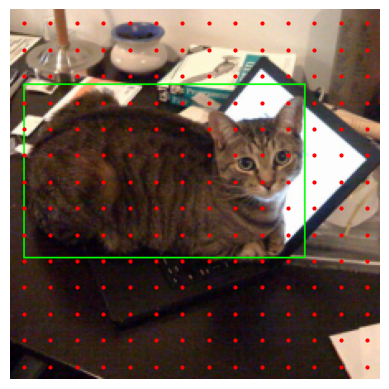

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 画像のサイズとグリッドの設定
image_size = (224, 224)
grid_size = (14, 14)

# グリッドのセルの幅と高さを計算
cell_width = image_size[0] // grid_size[0]
cell_height = image_size[1] // grid_size[1]

# 中心点の座標を計算
center_points = []
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        center_x = i * cell_width + cell_width // 2
        center_y = j * cell_height + cell_height // 2
        center_points.append((center_x, center_y))

# 元の画像を読み込み

# 画像を表示
plt.imshow(image_rgb)

# 中心点をプロット
for center_point in center_points:
    plt.plot(center_point[0], center_point[1], 'ro', markersize=2)  # 'ro'は赤い円形のマーカー

# 軸を表示しない設定
plt.axis('off')

# プロットした画像を表示
plt.show()

次にbbox内のpatchのみを取り出し，中心点を可視化させる

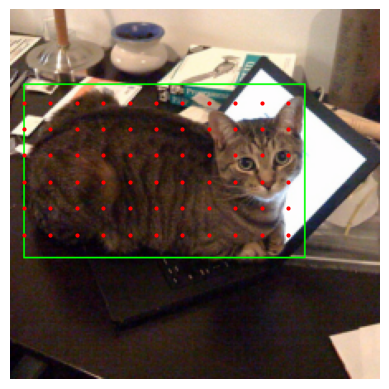

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# 画像のサイズとグリッドの設定
image_size = (224, 224)
grid_size = (14, 14)

# BBOXの座標
bbox = x,y,w,h

# グリッドのセルの幅と高さを計算
cell_width = image_size[0] // grid_size[0]
cell_height = image_size[1] // grid_size[1]

# BBOXの範囲内にあるセルの中心点を取得
center_points = []
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        center_x = i * cell_width + cell_width // 2
        center_y = j * cell_height + cell_height // 2
        if bbox[0] <= center_x <= bbox[0] + bbox[2] and bbox[1] <= center_y <= bbox[1] + bbox[3]:
            center_points.append((center_x, center_y))

# 元の画像を読み込み
# image = plt.imread()

# 画像を表示
plt.imshow(image_rgb)

# 中心点をプロット
marker_size = 2  # マーカーの大きさ
for center_point in center_points:
    plt.plot(center_point[0], center_point[1], 'ro', markersize=marker_size)  # マーカーの大きさを設定

# BBOXをプロット
# plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none'))

# 軸を表示しない設定
plt.axis('off')

# プロットした画像を表示
plt.show()

### まとめ

上記のcodeを関数にして自己教師ありに入れつなげる<br>
初めに画像を正方形に直し，bboxの座標を計算し返す関数

In [50]:
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms

def reshape_func(image_file, target):#sslに入れるための正方形の画像とそれに対応する計算しなおしたbboxを出力する

    IMAGENET_MEAN = [0.485, 0.456, 0.406] #imagenetの正規化
    IMAGENET_STD = [0.229, 0.224, 0.225]
    IMAGENET_SIZE = 224

    #２枚の画像を比べる(余白なし)

    transform1 = transforms.Resize(224)
    transform2 = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((IMAGENET_MEAN), (IMAGENET_STD))
        ])

    # 画像ファイルのパスを指定する

    img = cv2.imread(image_file)
    reshaeped_im = transform1(Image.open(image_file))
    transformed_image = transform2(reshaeped_im).to("cuda")
    new_width = reshaeped_im.size[0]
    new_height = reshaeped_im.size[1]


    resize_ratio_x = new_width / img.shape[1]
    resize_ratio_y = new_height / img.shape[0]


    # 画像ファイル名から画像IDを取得する
    image_id = None
    for image_info in coco.dataset['images']:
        if image_info['file_name'] == os.path.basename(image_file):
            image_id = image_info['id']
            break

    if image_id is not None:
        # 画像IDに対応するアノテーション情報を取得する
        annotations_ids = coco.getAnnIds(imgIds=image_id)
        annotations = coco.loadAnns(annotations_ids)

        # BBOXを取得
        for annotation in annotations:
            bbox = annotation['bbox']
            resized_bbox = [
            int((bbox[0] * resize_ratio_x) - ((reshaeped_im.size[0] - 224) / 2)),
            int((bbox[1] * resize_ratio_y) - ((reshaeped_im.size[1] - 224) / 2)),
            int(bbox[2] * resize_ratio_x),
            int(bbox[3] * resize_ratio_y)
            ]
            label = coco.loadCats(annotation['category_id'])[0]['name']
            if label == target:
                
                return transformed_image, resized_bbox

確認

In [53]:
reshape_func(image_file, 'cat')

(tensor([[[ 1.2728,  1.3070,  1.3242,  ..., -0.3712, -0.4397, -0.5767],
          [ 1.2899,  1.3242,  1.3584,  ..., -0.5253, -0.5767, -0.5424],
          [ 1.2043,  1.2385,  1.2385,  ..., -0.5082, -0.5253, -0.5596],
          ...,
          [-1.8268, -1.7069, -1.8097,  ...,  2.0263,  2.0605,  2.0777],
          [-1.9638, -1.9295, -1.8610,  ...,  2.0092,  2.0777,  2.0777],
          [-1.7754, -1.8097, -1.6727,  ...,  2.0263,  2.1290,  2.1119]],
 
         [[ 1.0630,  1.1155,  1.0805,  ..., -1.0553, -0.9328, -1.0028],
          [ 0.9405,  0.9930,  1.0805,  ..., -1.0203, -1.0028, -0.8627],
          [ 0.9405,  0.9930,  1.0105,  ..., -1.0028, -1.0203, -0.9328],
          ...,
          [-1.8081, -1.6681, -1.6506,  ...,  1.6758,  1.6057,  1.6232],
          [-1.6856, -1.6856, -1.5805,  ...,  1.6408,  1.6232,  1.6057],
          [-1.7206, -1.8081, -1.6506,  ...,  1.7108,  1.6933,  1.6583]],
 
         [[ 0.9319,  0.8797,  0.8099,  ..., -0.8458, -0.9678, -1.0898],
          [ 0.8971,  0.9494,

上記のbboxと同じ．関数は問題なさそう

次に自己教師ありのモデルと，最終層を抽出する関数

In [54]:
vitb16 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
model = vitb16.to("cuda")

def extract(target, inputs):#抽出する関数
    feature = None

    def forward_hook(module, inputs, outputs):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs)

    # コールバック関数を解除する。
    handle.remove()

    return features

Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main


次にpatchのidをとってくる関数

In [55]:
def get_id(bbox):#idをとってくるように変更済み。ちゃんととってきているか確認したい場合はcenter_pointsを返すようにする
    # 画像のサイズとグリッドの設定
    image_size = (224, 224)
    grid_size = (14, 14)

    # BBOXの座標

    # グリッドのセルの幅と高さを計算
    cell_width = image_size[0] // grid_size[0]
    cell_height = image_size[1] // grid_size[1]

    # BBOXの範囲内にあるセルの中心点を取得
    center_points = []
    id = []
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            center_x = i * cell_width + cell_width // 2
            center_y = j * cell_height + cell_height // 2
            if bbox[0] <= center_x <= bbox[0] + bbox[2] and bbox[1] <= center_y <= bbox[1] + bbox[3]:
                center_points.append((center_x, center_y))
                id.append([i,j])
    
    return id

確認

In [56]:
bbox = [8, 45, 170, 105]

In [57]:
get_id(bbox)

[[0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 8],
 [2, 3],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [2, 8],
 [3, 3],
 [3, 4],
 [3, 5],
 [3, 6],
 [3, 7],
 [3, 8],
 [4, 3],
 [4, 4],
 [4, 5],
 [4, 6],
 [4, 7],
 [4, 8],
 [5, 3],
 [5, 4],
 [5, 5],
 [5, 6],
 [5, 7],
 [5, 8],
 [6, 3],
 [6, 4],
 [6, 5],
 [6, 6],
 [6, 7],
 [6, 8],
 [7, 3],
 [7, 4],
 [7, 5],
 [7, 6],
 [7, 7],
 [7, 8],
 [8, 3],
 [8, 4],
 [8, 5],
 [8, 6],
 [8, 7],
 [8, 8],
 [9, 3],
 [9, 4],
 [9, 5],
 [9, 6],
 [9, 7],
 [9, 8],
 [10, 3],
 [10, 4],
 [10, 5],
 [10, 6],
 [10, 7],
 [10, 8]]

手書きでの座標と一致．関数は問題なさそう．

内積を計算し，最大値が，bbox内に当たる数をカウントして何個中何個が当たったかを計算する関数

In [ ]:
def dot_count(id_1,emb_1,id_2,emb_2):
    
    A = 0 #最大値がbboxの中に履いている個数

    for i in range(len(id_1)):
        n = id_1[i][0] #行
        m = id_1[i][1] #列

        id_emb = n*14+m #196の中のどこに当たるのか
        # print(id_emb)
        emb1 = emb_1[id_emb]
        # print(emb1.shape)

        inner_product = torch.matmul(emb_2,emb1)
        max_index = torch.argmax(inner_product).item()

        k = max_index // 14 #最大値に当たるpatchの行
        l = max_index % 14 #最大値に当たるpatchの列

        max_id = [k, l] #maxのid（行，列）
        # print(f"maxid:{max_id}")

        if max_id in id_2:
            A += 1
    
    # print(f"count数:{A}")
    # print(f"bbox内のpatchの数:{len(id_1)}")

    if A == 0:
        wariai = 0

    wariai = A/len(id_1)

    return wariai